In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [6]:
# Read in file
d_df = pd.read_csv('../data/IRD/deaths.csv')
# Drop China and Diamond Princess
for c in ['China', 'Diamond Princess']:
    d_df = d_df[d_df['Country/Region']!=c]
d_df['Country/Region'].iloc[~d_df['Province/State'].isnull().values] += ' / '+d_df['Province/State']
d_df = d_df.drop(columns=['Province/State', 'Lat', 'Long'])
d_df.set_index(keys='Country/Region', inplace=True)
# Drop low deaths
d_df = d_df[(d_df.max(axis=1)>20)]

In [7]:
deaths = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>1000), axis=1)
for i, country in enumerate(d_df.index):
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            deaths[country] = d_df.T[country].values[start_days[i]:end_days[i]]
        else:
#             print('hello')
            deaths[country] = d_df.T[country].values[start_days[i]:]

In [8]:
len(deaths)

78

# Bayesian Model

In [9]:
def sigmoid(a, t0, t):
    return 1.0/(1.0+np.exp(-a*(t-t0)))

In [10]:
def step_inter(Di, GR0, GR1, a, t0, t):
    D = [Di,]
    for i in range(1, len(t)):
        D.append(D[i-1]*(GR0*(1-sigmoid(a, t0, t[i]))+GR1*sigmoid(a, t0, t[i])))
    return np.array(D)

In [11]:
def model():
    
    N = len(deaths)
    
    Di = numpyro.sample('Di', dist.Normal(7.0*np.ones(N), 3.0*np.ones(N)))
    GR1 = numpyro.sample('GR1', dist.Normal(1.33*np.ones(N), 0.5*np.ones(N)))
    GR2 = numpyro.sample('GR2', dist.Normal(1.2*np.ones(N), 0.5*np.ones(N)))
    t0 = numpyro.sample('t0', dist.Normal(15*np.ones(N), 5*np.ones(N)))
    Decay = numpyro.sample('Decay', dist.Normal(1.0*np.ones(N), 0.5*np.ones(N)))
    
    # Create likelihood for each country    
    for i, country in enumerate(deaths):
        dead = deaths[country]
        t = np.arange(len(dead))
        prediction = step_inter(Di[i], GR1[i], GR2[i], Decay[i], t0[i], t)
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [13]:
N = len(deaths)

init_params = {'Di': 7.0*np.ones((N_chains, N)),
               'GR1': 1.33*np.ones((N_chains, N)),
               'GR2': 1.2*np.ones((N_chains, N)),
               't0': 15.0*np.ones((N_chains, N)),
               'Decay': 1.0*np.ones((N_chains, N)),
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2500, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [14]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 31001.00631213188 s


In [15]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  Decay[0]      0.95      0.54      0.97     -0.02      1.74   1035.67      1.01
  Decay[1]      0.86      0.51      0.84      0.03      1.57   1355.32      1.00
  Decay[2]      1.12      0.38      1.08      0.51      1.74   3519.15      1.00
  Decay[3]      0.92      0.53      0.93      0.02      1.71    909.93      1.00
  Decay[4]      0.84      0.51      0.81      0.03      1.55   2791.64      1.00
  Decay[5]      0.83      0.61      0.86     -0.05      1.70    146.84      1.02
  Decay[6]      0.49      0.32      0.38      0.12      0.93   1332.82      1.00
  Decay[7]      0.99      0.51      0.98      0.05      1.73    646.79      1.01
  Decay[8]      0.97      0.52      0.98      0.08      1.82   1020.95      1.00
  Decay[9]      0.86      0.44      0.81      0.08      1.49   2892.91      1.00
 Decay[10]      1.01      0.49      1.01      0.18      1.84   2312.87      1.00
 Decay[11]      0.79      0

Number of divergences: 1058


In [83]:
samples = {}
with h5py.File('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

In [23]:
import json

In [24]:
bcg_cov_est = json.load(open('BCG_Coverage_Estimates.json'))

Text(0, 0.5, 'Growth Rate [per day]')

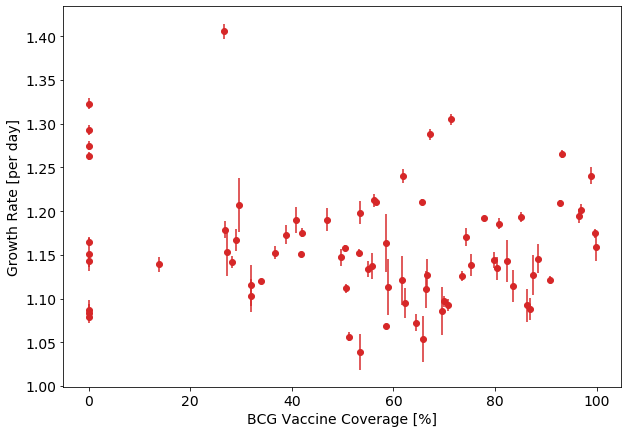

In [37]:
plt.figure(figsize=(10,7))
for i, c in enumerate(bcg_countries+nonbcg_countries+other):
    try:
        plt.errorbar(bcg_cov_est[c], np.mean(samples['GR'][:,i]), 
                     yerr=np.std(samples['GR'][:,i]), color='tab:red', fmt='o')
    except:
        continue
plt.xlabel('BCG Vaccine Coverage [%]')
plt.ylabel('Growth Rate [per day]')

In [38]:
deaths

{'Afghanistan': array([ 4,  4,  4,  4,  4,  4,  4,  6,  6,  7,  7, 11, 14, 14, 15, 15, 18,
        18, 21, 23, 25]),
 'Albania': array([ 4,  5,  5,  6,  8, 10, 10, 11, 15, 15, 16, 17, 20, 20, 21, 22, 22,
        23, 23, 23, 23, 23, 24, 25]),
 'Algeria': array([  4,   4,   4,   7,   9,  11,  15,  17,  17,  19,  21,  25,  26,
         29,  31,  35,  44,  58,  86, 105, 130, 152, 173, 193, 205, 235,
        256, 275, 293, 313, 326, 336]),
 'Andorra': array([ 6,  8, 12, 14, 15, 16, 17, 18, 21, 22, 23, 25, 26, 26, 29, 29, 31,
        33]),
 'Argentina': array([  4,   4,   4,   6,   8,   9,  13,  18,  19,  23,  27,  28,  36,
         39,  43,  44,  48,  56,  63,  72,  82,  83,  90,  97, 102, 111]),
 'Armenia': array([ 4,  7,  7,  7,  7,  8,  8,  9, 10, 12, 13, 13, 14, 16, 17]),
 'Australia / New South Wales': array([ 4,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9, 10,
        12, 12, 16, 18, 21, 21, 21, 22, 23, 24, 25, 25, 25]),
 'Australia / Victoria': array([ 4,  4,  4,  4,  

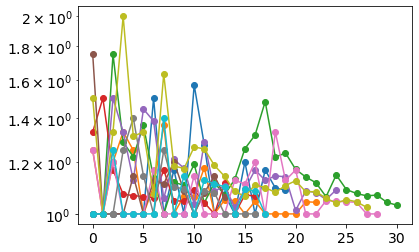

In [55]:
n = 1
for i, c in enumerate(deaths):
    if i==10:
        break
    plt.semilogy((deaths[c][:-n]/deaths[c][n:])**(-1/n), 'o-')

Text(0, 0.5, 'Count')

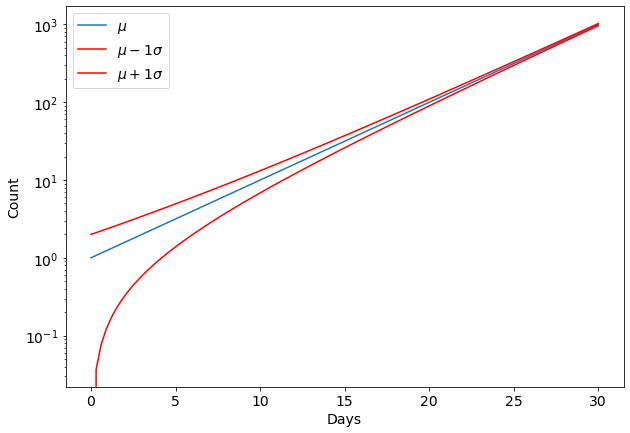

In [73]:
x = np.linspace(0, 30, 100)
a = 0.23
y = np.exp(a*x)

plt.figure(figsize=(10,7))
plt.semilogy(x, y, label=r'$\mu$')
plt.semilogy(x, y-np.sqrt(y), 'r', label=r'$\mu-1\sigma$')
plt.semilogy(x, y+np.sqrt(y), 'r', label=r'$\mu+1\sigma$')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')

In [74]:
from scipy.integrate import simps

In [99]:
def dexp(N_p, T_p, tau_0, t_0, t):
    r = T_p/tau_0
    y = (t-tau_0)/T_p
    x = np.linspace(y, 1001)
    int_range = np.linspace(0, 1, 101)
    norm = simps(np.exp(r*int_range*np.exp(-int_range))-1, int_range)
    return N_p*(simps(np.exp(r*x*np.exp(-x))-1, x))/norm

(-100, 10.0)

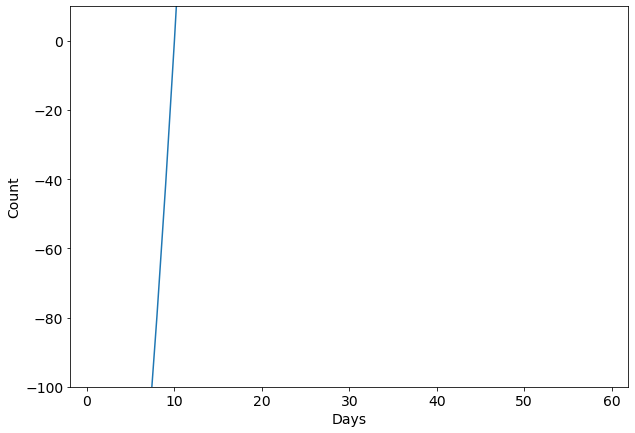

In [141]:
x = np.arange(1, 60)
N_p, T_p, tau_0, t_0 = [1e3, 100, 10, 0]
y = np.array([dexp(N_p, T_p, tau_0, t_0, t) for t in x])

plt.figure(figsize=(10,7))
plt.plot(x, y, label=r'$\mu$')
# plt.semilogy(x, y, label=r'$\mu$')
# plt.semilogy(x, y-np.sqrt(y), 'r', label=r'$\mu-1\sigma$')
# plt.semilogy(x, y+np.sqrt(y), 'r', label=r'$\mu+1\sigma$')
# plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')
plt.ylim(-100, 1e1)
# plt.ylim(1, 1e2*N_p)

In [153]:
def time_dep_growth(a, b, x):
    return ((a/x)**b+1)**x

Text(0, 0.5, 'Count')

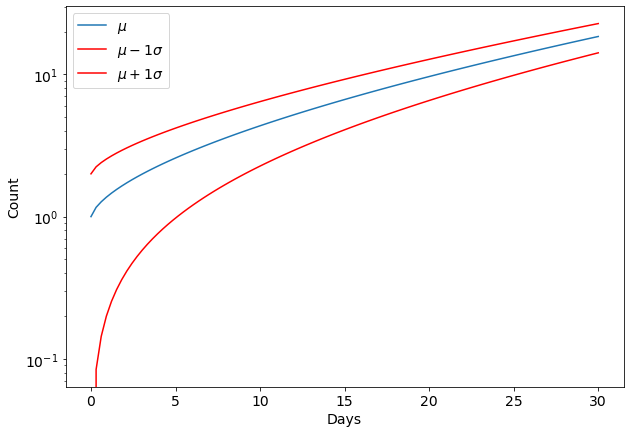

In [161]:
x = np.linspace(0, 30, 100)
a, b = 1e-1, 0.4
y = time_dep_growth(a, b, x)

plt.figure(figsize=(10,7))
plt.semilogy(x, y, label=r'$\mu$')
plt.semilogy(x, y-np.sqrt(y), 'r', label=r'$\mu-1\sigma$')
plt.semilogy(x, y+np.sqrt(y), 'r', label=r'$\mu+1\sigma$')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')

In [21]:
def dblexp(a, b, x):
    return a**(x*b**-x)

Text(0, 0.5, 'Count')

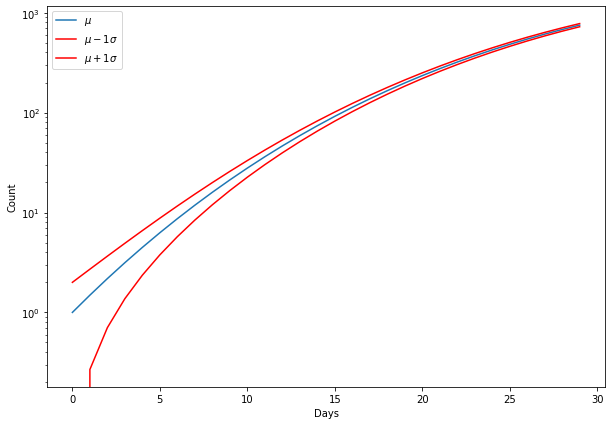

In [42]:
x = np.arange(30)
a, b = 1.5, 1.02
y = dblexp(a, b, x)

plt.figure(figsize=(10,7))
plt.semilogy(x, y, label=r'$\mu$')
plt.semilogy(x, y-np.sqrt(y), 'r', label=r'$\mu-1\sigma$')
plt.semilogy(x, y+np.sqrt(y), 'r', label=r'$\mu+1\sigma$')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')

In [52]:
def sigmoid(a, t0, t):
    return 1.0/(1.0+np.exp(-a*(t-t0)))

In [66]:
def step_inter(Di, GR0, GR1, a, t0, t):
    D = [Di,]
    for i in range(1, len(t)):
        D.append(D[i-1]*(GR0*(1-sigmoid(a, t0, t[i]))+GR1*sigmoid(a, t0, t[i])))
    return np.array(D)

Text(0, 0.5, 'Count')

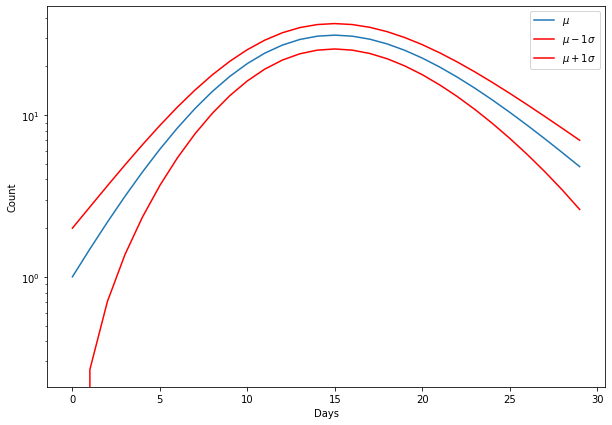

In [74]:
x = np.arange(30)
# a, t0 = 1.5, 10
# y = sigmoid(a, t0, x)
y = step_inter(1, 1.6, 0.8, 0.2, 10, x)

plt.figure(figsize=(10,7))
plt.semilogy(x, y, label=r'$\mu$')
plt.semilogy(x, y-np.sqrt(y), 'r', label=r'$\mu-1\sigma$')
plt.semilogy(x, y+np.sqrt(y), 'r', label=r'$\mu+1\sigma$')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')

# Example Plots

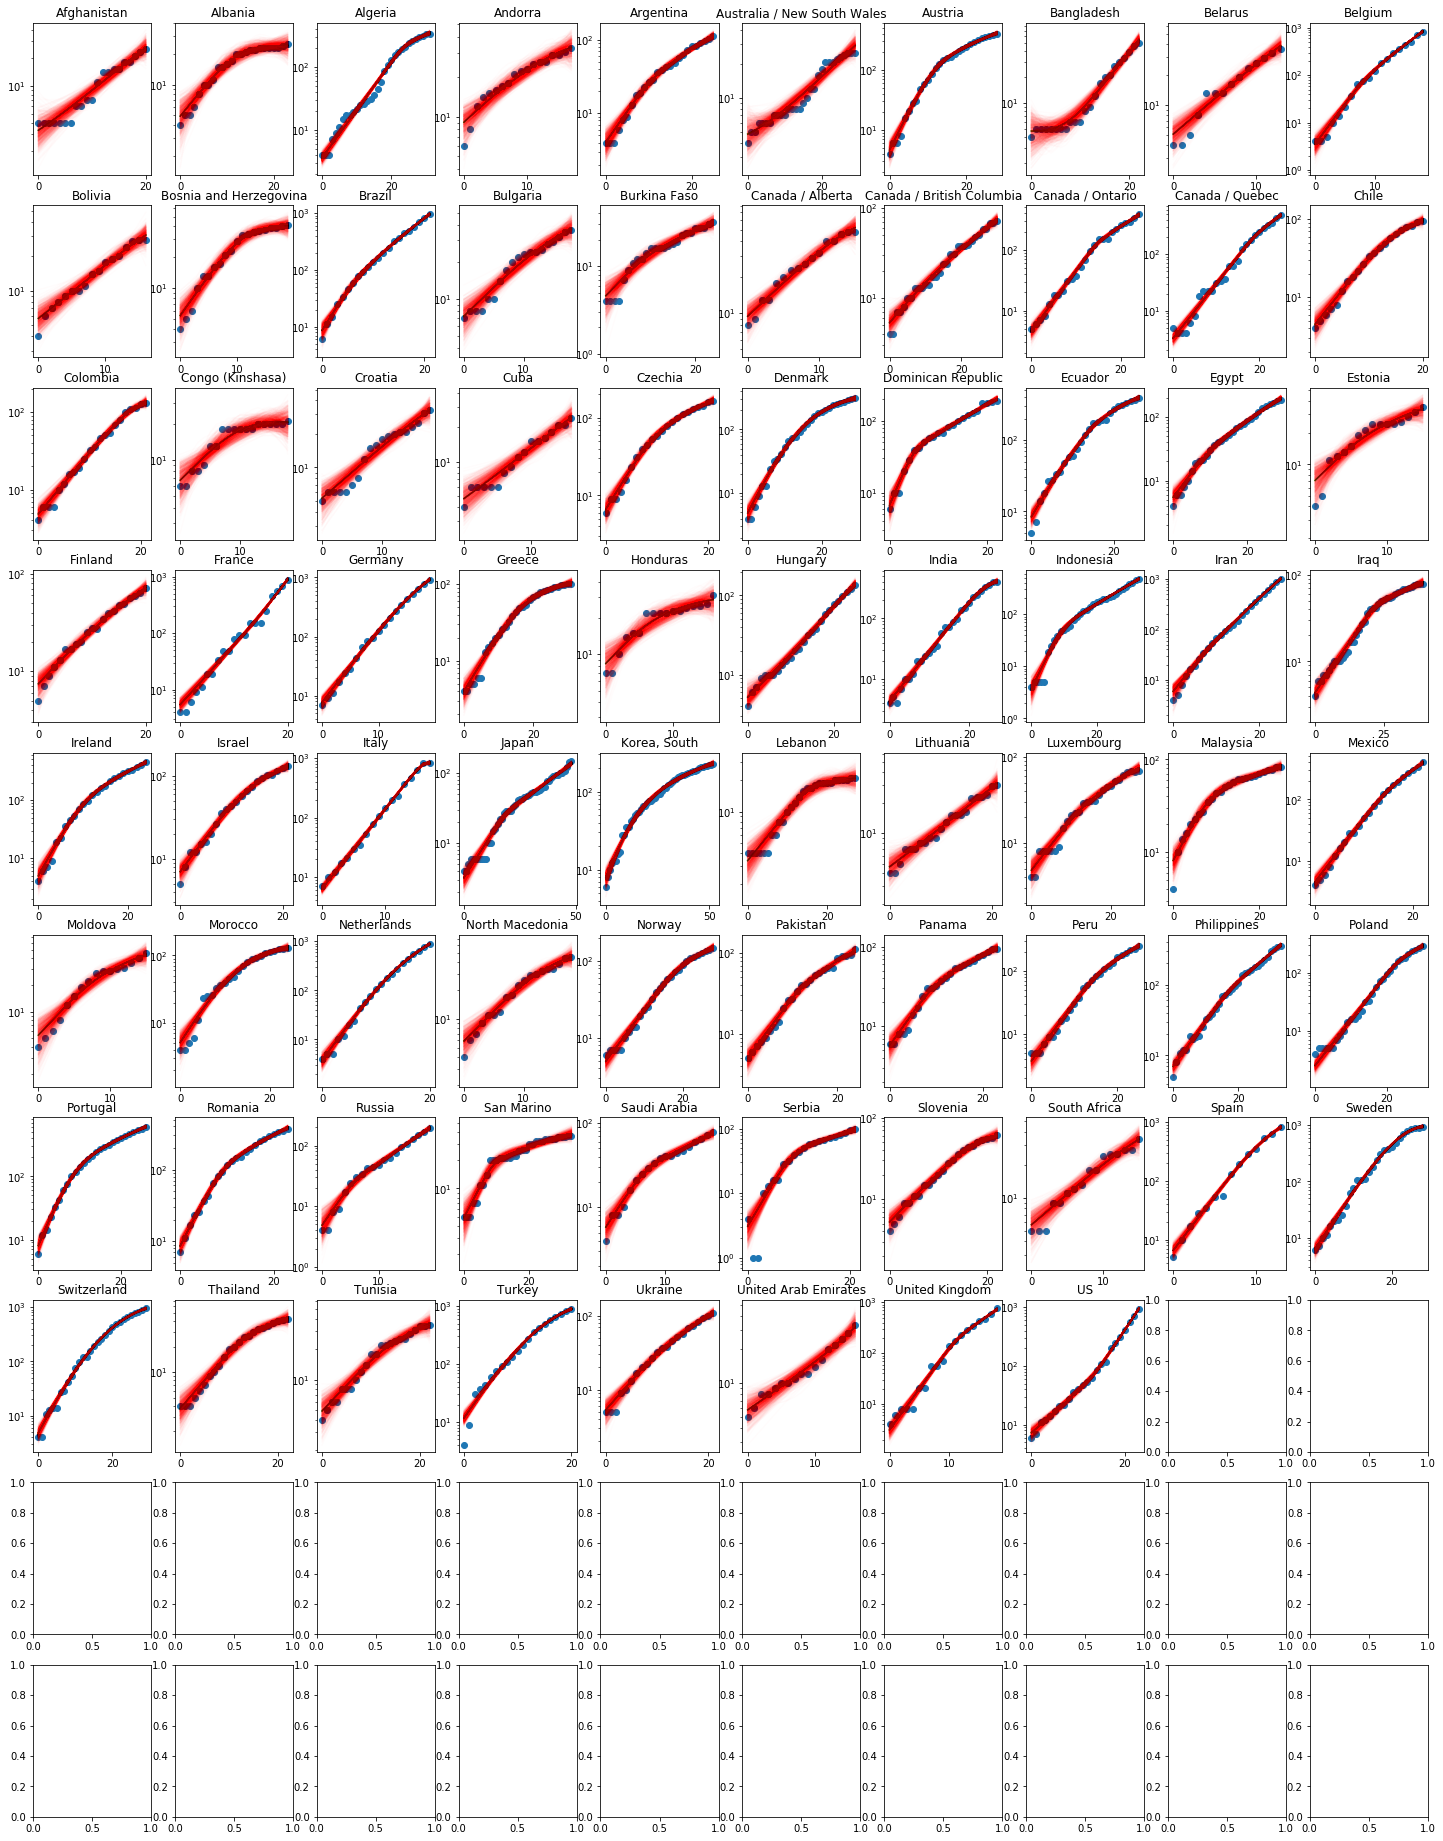

In [53]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(10, 10, figsize=(fig_scale*25,fig_scale*33))
a = ax.flatten()
for i, c in enumerate(deaths):
    t = np.arange(len(deaths[c]))
    a[i].set_title(c)
    a[i].plot(deaths[c], 'o')
    a[i].semilogy(np.mean(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                                     samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
                                     samples['t0'][::10,i].T, t[:,None]), axis=1), 'g', alpha=1)
    a[i].plot(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                         samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
                         samples['t0'][::10,i].T, t[:,None]), 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1.0_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

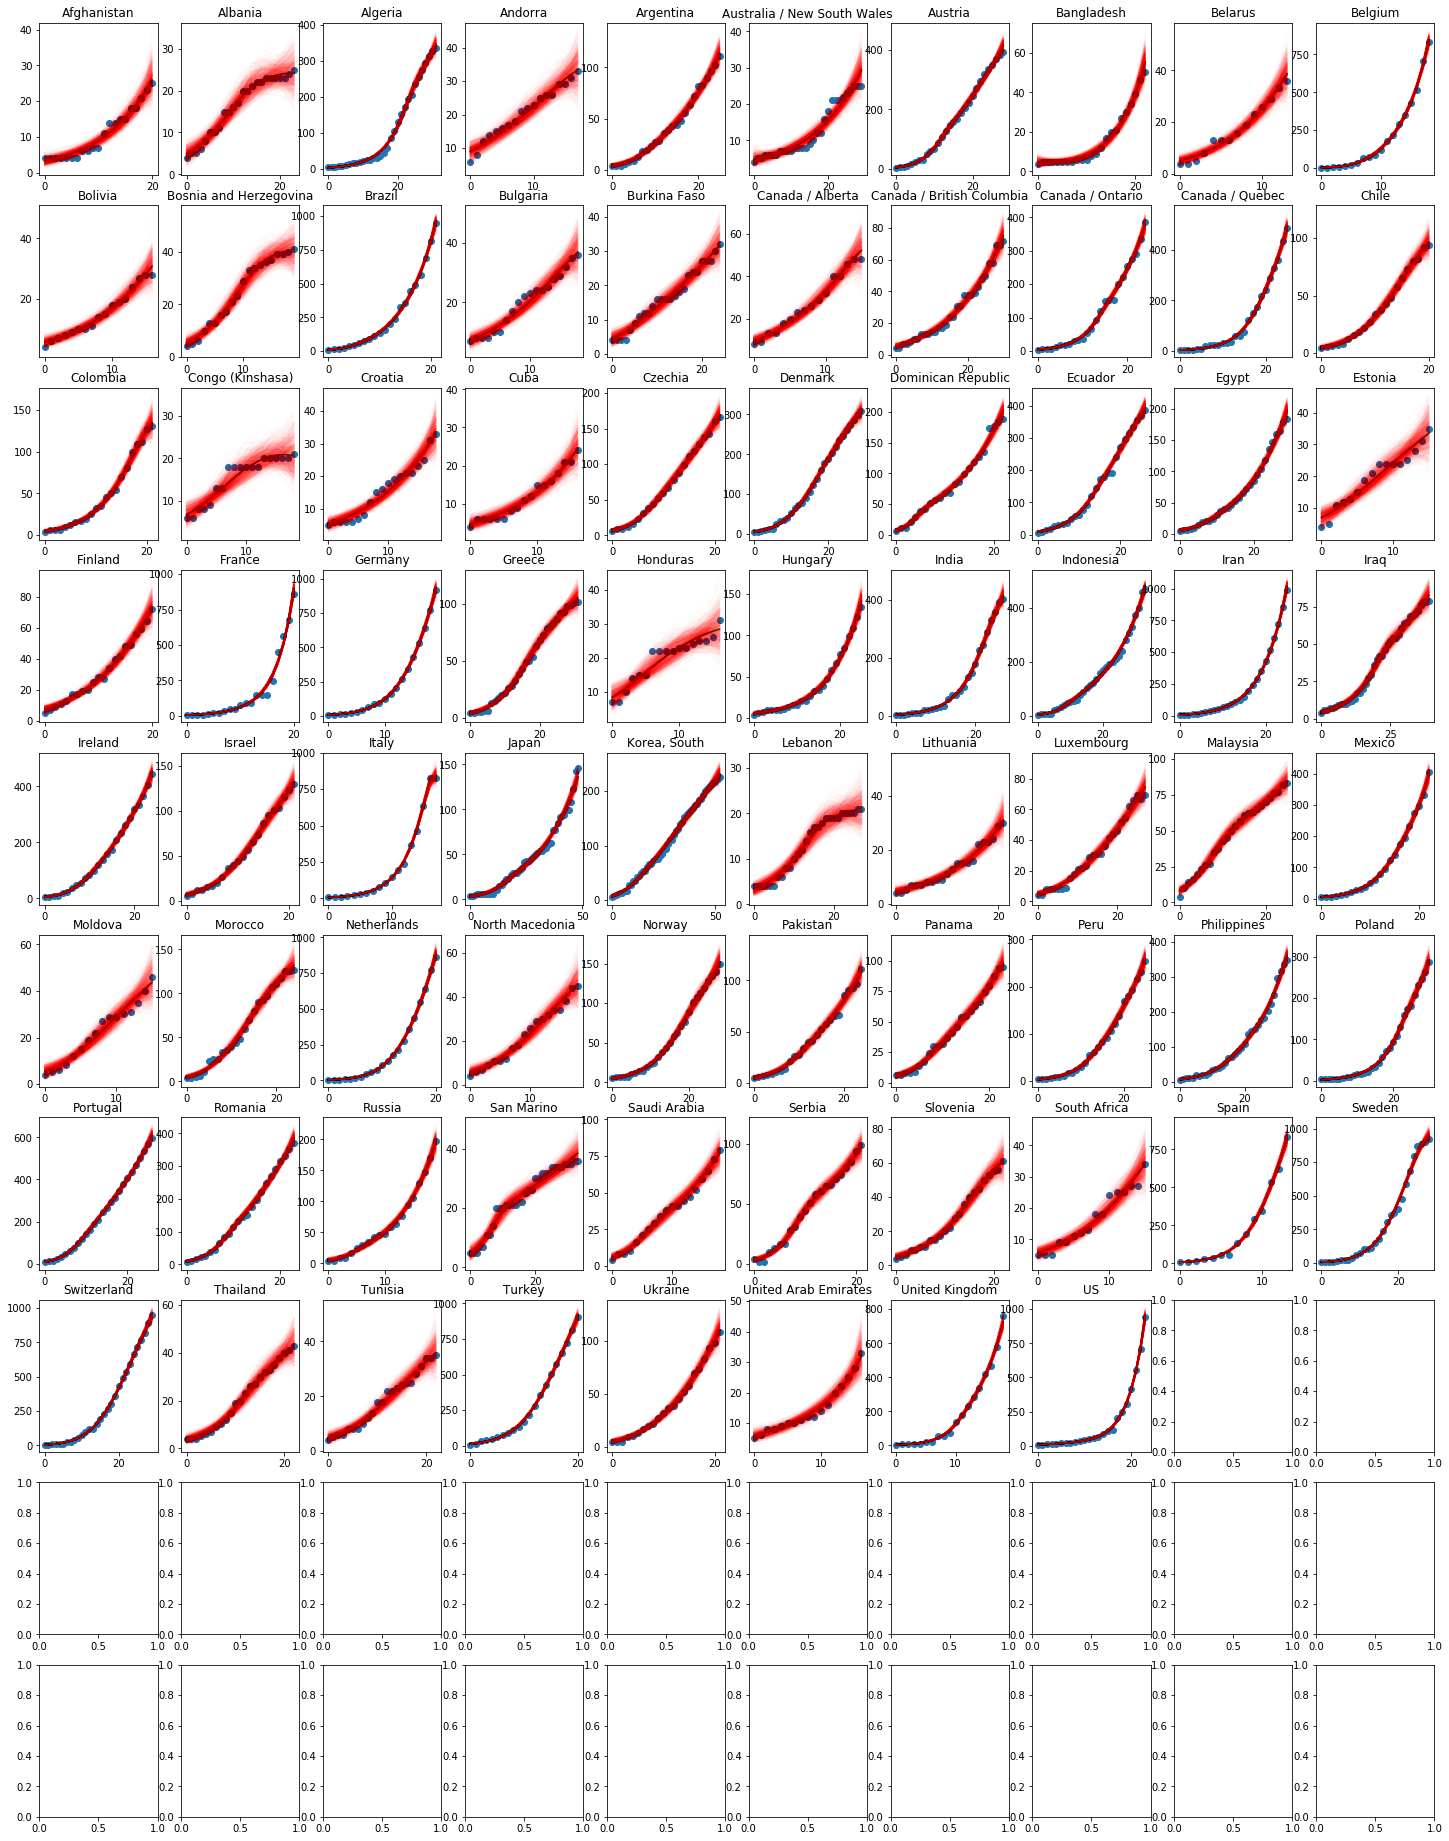

In [54]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(10, 10, figsize=(fig_scale*25,fig_scale*33))
a = ax.flatten()
for i, c in enumerate(deaths):
    t = np.arange(len(deaths[c]))
    a[i].set_title(c)
    a[i].plot(deaths[c], 'o')
    a[i].plot(np.mean(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                                     samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
                                     samples['t0'][::10,i].T, t[:,None]), axis=1), 'g', alpha=1)
    a[i].plot(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                         samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
                         samples['t0'][::10,i].T, t[:,None]), 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1.0_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

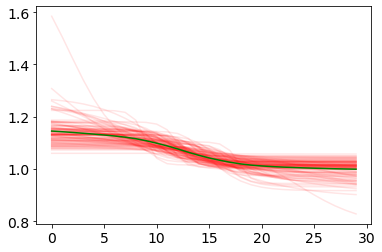

In [79]:
step = 100
i = 1
t = np.arange(30)
plt.plot((samples['GR1'][::step,i,None]*(1-sigmoid(samples['Decay'][::step,i,None], 
                                    samples['t0'][::step,i,None], t[None,:])) + \
          samples['GR2'][::step,i,None]*sigmoid(samples['Decay'][::step,i,None], 
                                 samples['t0'][::step,i,None], t[None,:])).T, alpha=0.1, color='r');
plt.plot(np.mean((samples['GR1'][::step,i,None]*(1-sigmoid(samples['Decay'][::step,i,None], 
                                    samples['t0'][::step,i,None], t[None,:])) + \
          samples['GR2'][::step,i,None]*sigmoid(samples['Decay'][::step,i,None], 
                                 samples['t0'][::step,i,None], t[None,:])), axis=0), alpha=1, color='g');

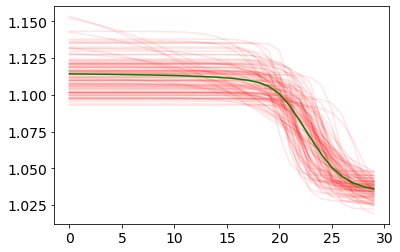

In [78]:
step = 100
i = 39
t = np.arange(30)
plt.plot((samples['GR1'][::step,i,None]*(1-sigmoid(samples['Decay'][::step,i,None], 
                                    samples['t0'][::step,i,None], t[None,:])) + \
          samples['GR2'][::step,i,None]*sigmoid(samples['Decay'][::step,i,None], 
                                 samples['t0'][::step,i,None], t[None,:])).T, alpha=0.1, color='r');
plt.plot(np.mean((samples['GR1'][::step,i,None]*(1-sigmoid(samples['Decay'][::step,i,None], 
                                    samples['t0'][::step,i,None], t[None,:])) + \
          samples['GR2'][::step,i,None]*sigmoid(samples['Decay'][::step,i,None], 
                                 samples['t0'][::step,i,None], t[None,:])), axis=0), alpha=1, color='g');

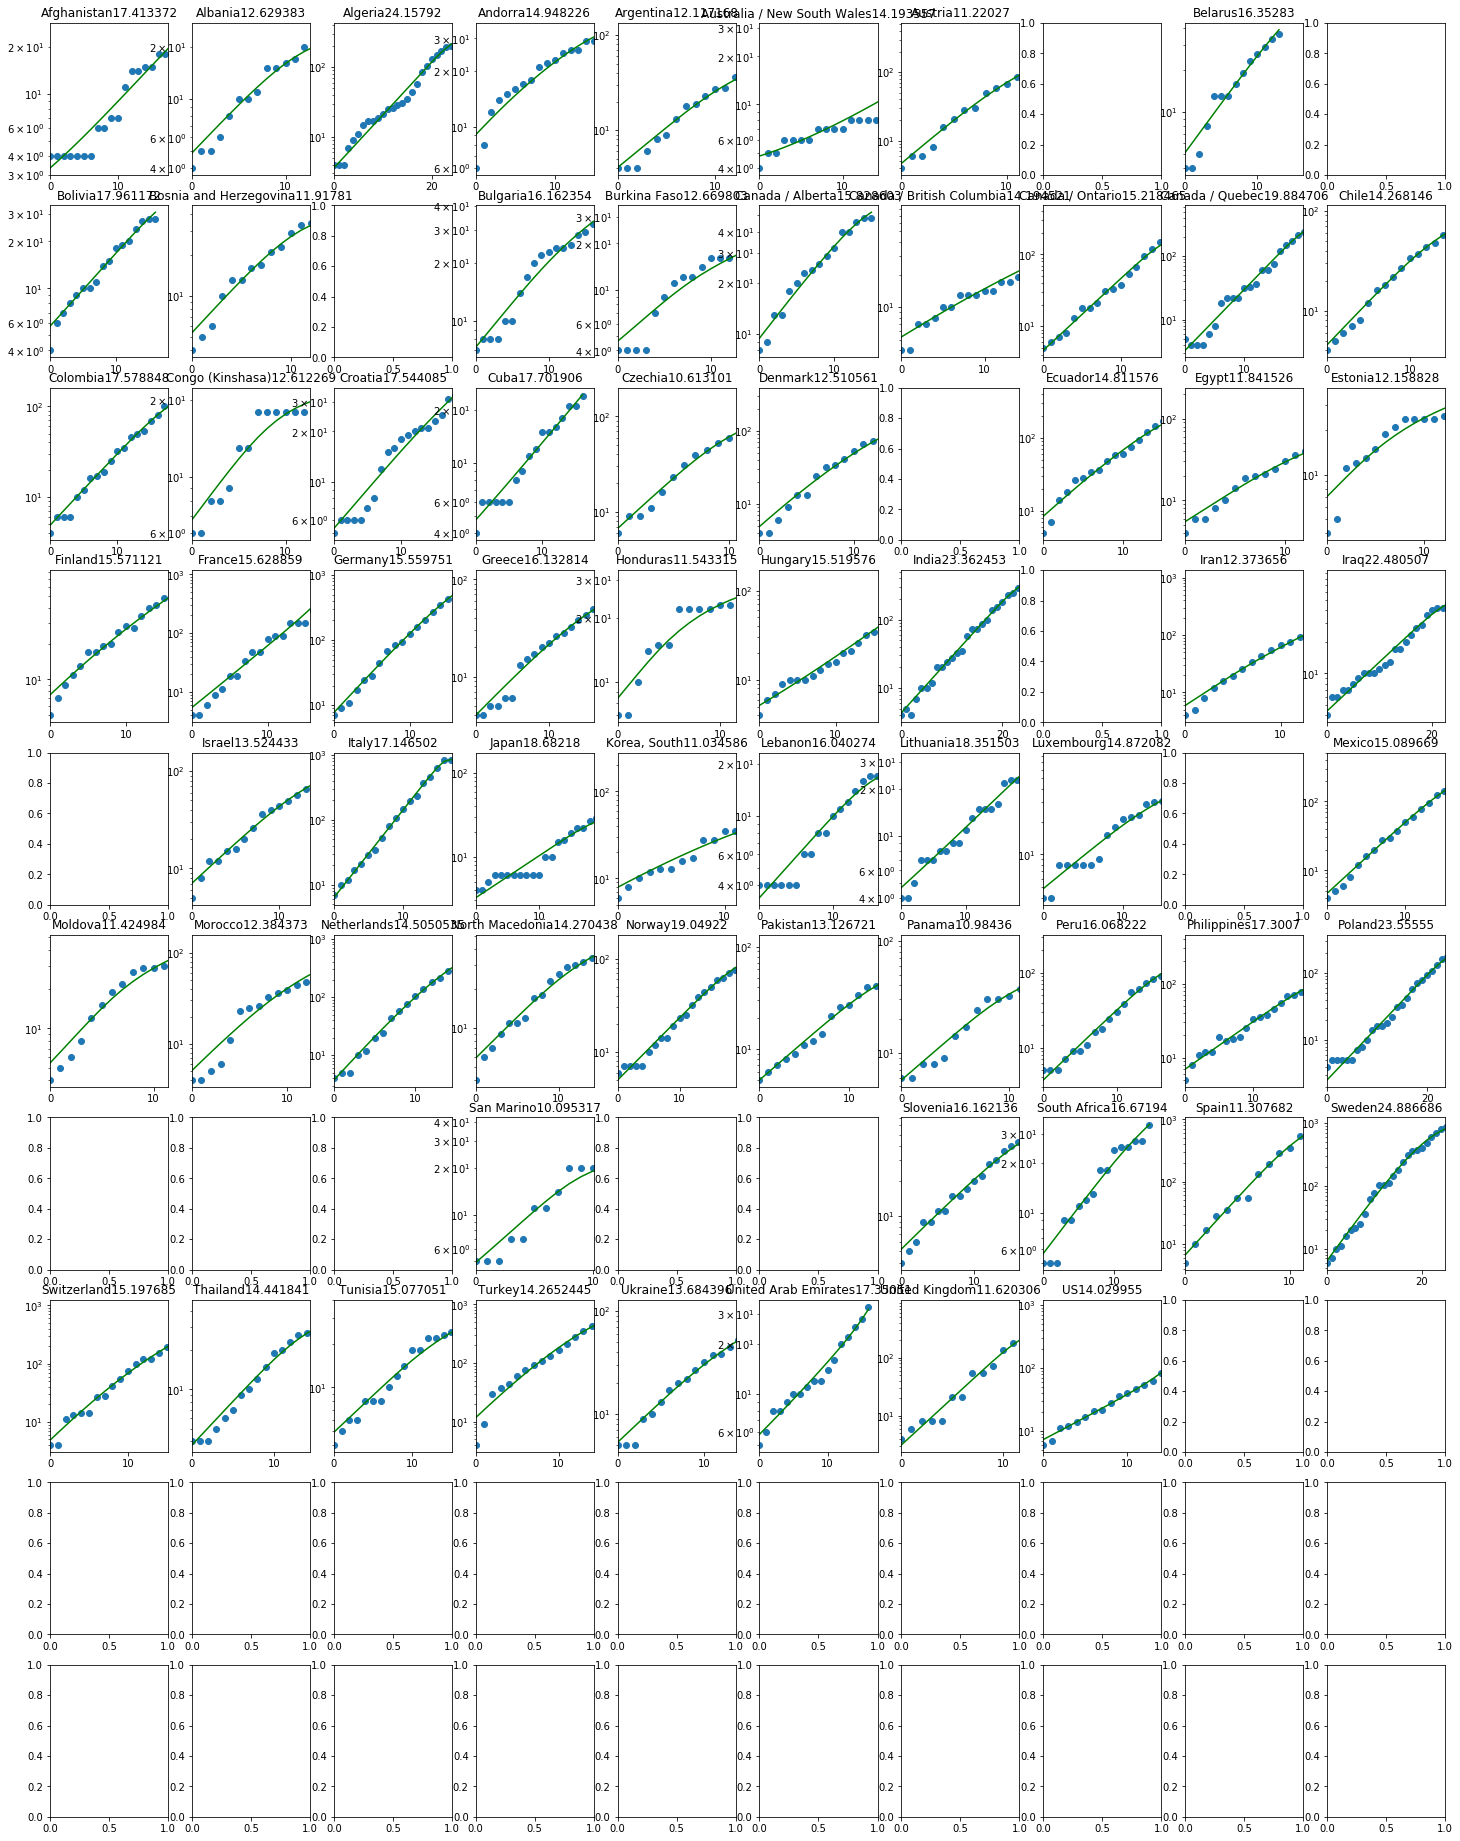

In [82]:
p = 0.5
tc = np.mean(-np.log((1./p)-1)/samples['Decay'] + samples['t0'], axis=0)

plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(10, 10, figsize=(fig_scale*25,fig_scale*33))
a = ax.flatten()
for i, c in enumerate(deaths):
    if tc[i] < 10:
        continue
    t = np.arange(len(deaths[c]))
    a[i].set_title(c+str(tc[i]))
    a[i].plot(deaths[c], 'o')
    a[i].semilogy(np.mean(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                                     samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
                                     samples['t0'][::10,i].T, t[:,None]), axis=1), 'g', alpha=1)
#     a[i].plot(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
#                          samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
#                          samples['t0'][::10,i].T, t[:,None]), 'r', alpha=0.01)
    
    a[i].set_xlim(0, tc[i] if tc[i]>0 else len(deaths[c]))
# plt.savefig('../plots/4.1.0_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

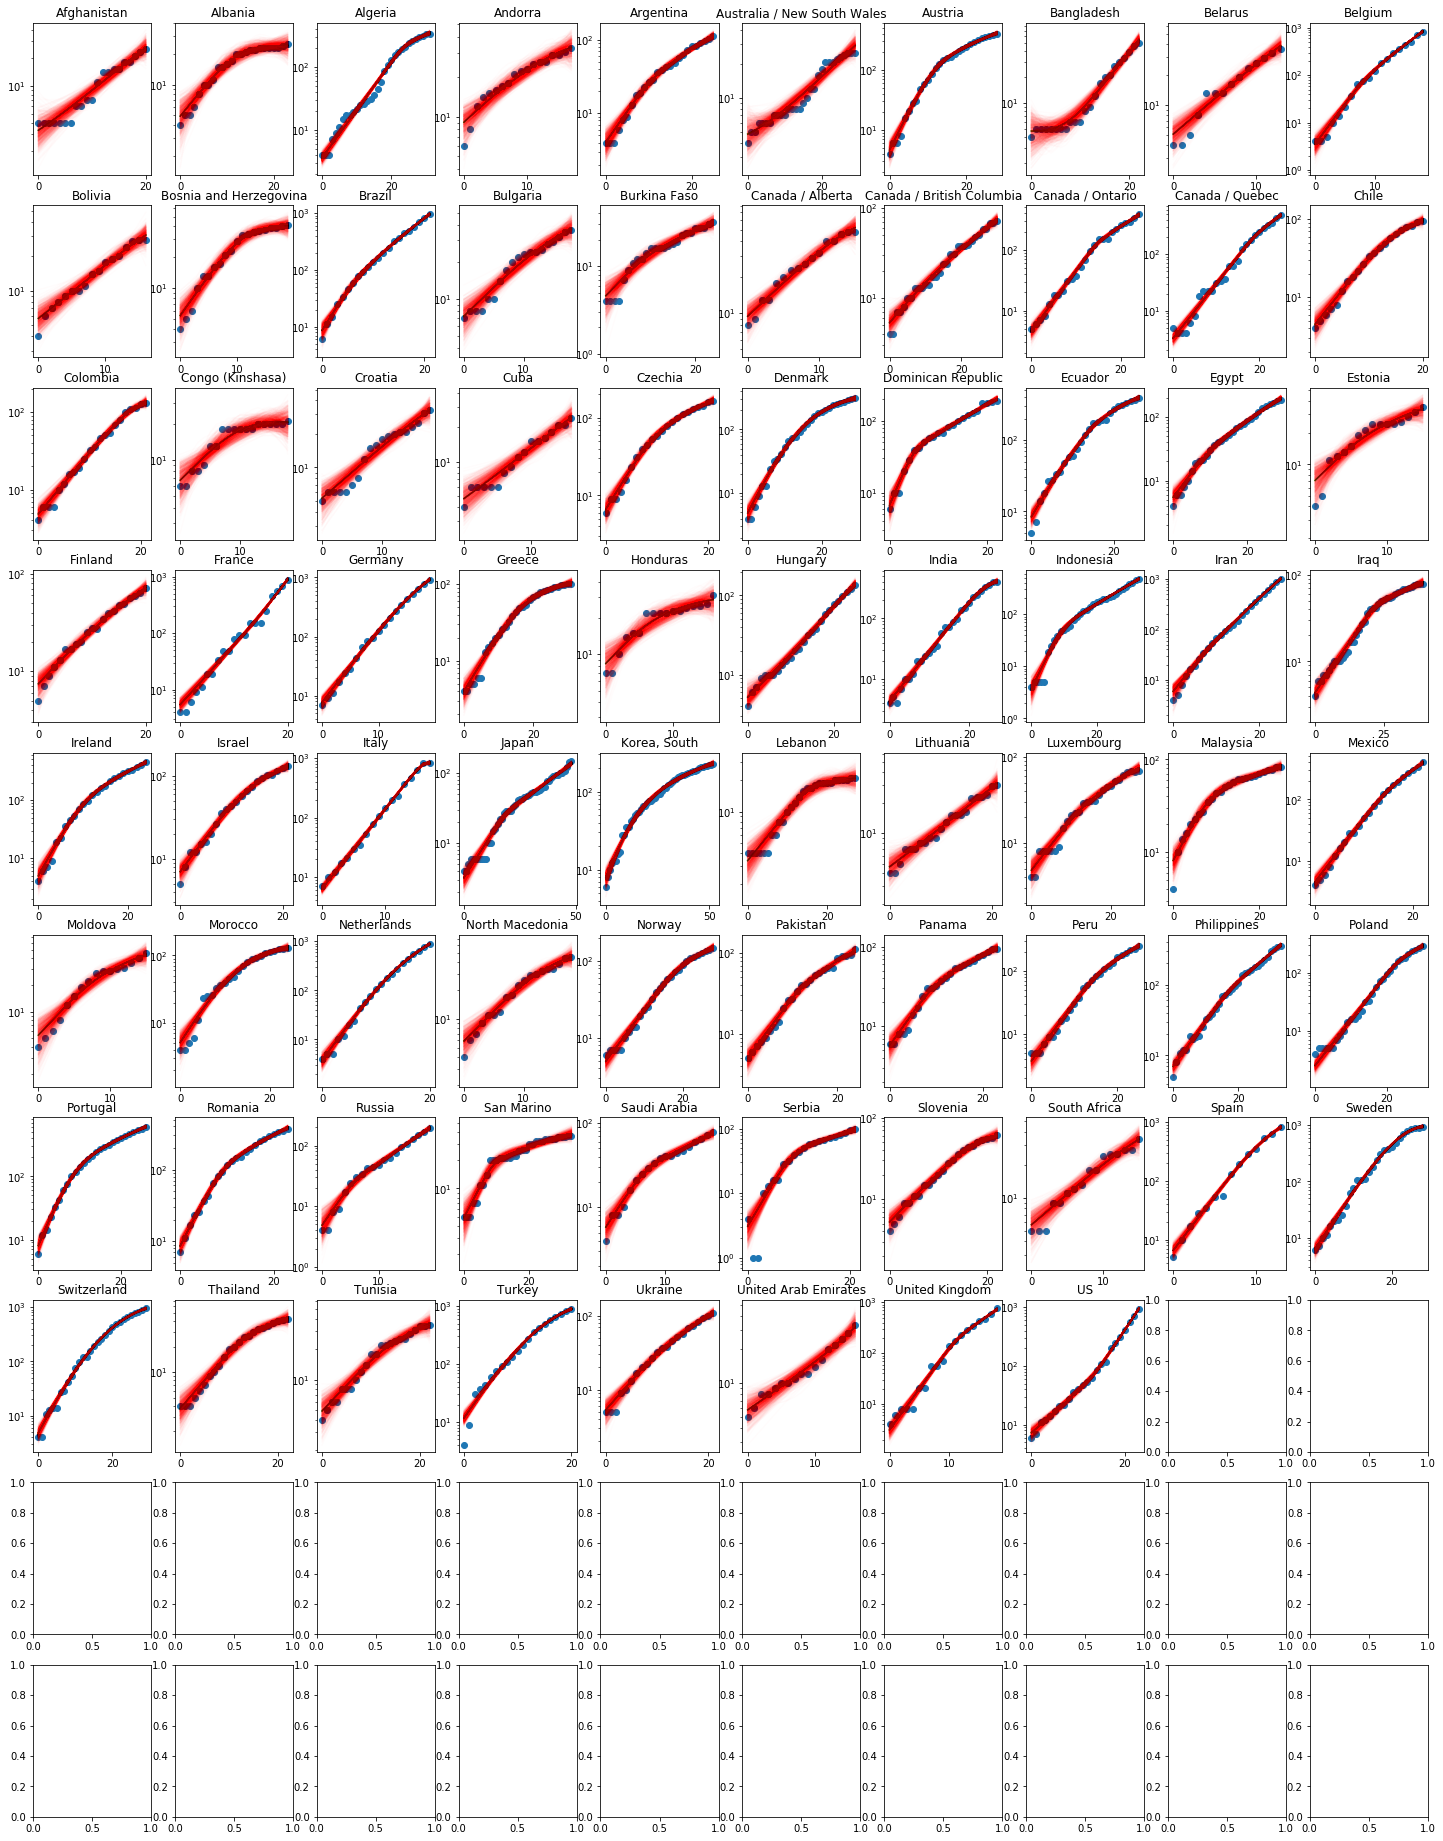

In [53]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(10, 10, figsize=(fig_scale*25,fig_scale*33))
a = ax.flatten()
for i, c in enumerate(deaths):
    t = np.arange(len(deaths[c]))
    a[i].set_title(c)
    a[i].plot(deaths[c], 'o')
    a[i].semilogy(np.mean(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                                     samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
                                     samples['t0'][::10,i].T, t[:,None]), axis=1), 'g', alpha=1)
    a[i].plot(step_inter(samples['Di'][::10,i].T, samples['GR1'][::10,i].T, 
                         samples['GR2'][::10,i].T, samples['Decay'][::10,i].T, 
                         samples['t0'][::10,i].T, t[:,None]), 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1.0_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

DeviceArray([ -0.7636235 ,   6.881309  ,  21.92165   ,  13.110588  ,
               6.10674   ,  37.184807  ,   4.97752   ,   5.7964435 ,
               8.234155  ,   5.4994903 ,  15.833773  ,   5.511345  ,
              -1.2493893 ,  19.729847  ,  12.06938   ,  13.832177  ,
              14.4889555 ,  12.666457  ,  17.355688  ,   7.8754106 ,
              13.307158  ,   7.350634  ,  18.94673   ,  13.025634  ,
               4.1556807 ,  -5.701153  ,   3.2360487 ,  -0.80227095,
               3.480781  ,   7.217173  ,   7.0927386 ,  16.141384  ,
               5.6246967 ,   4.7118926 ,   5.326549  ,  19.864199  ,
              20.200285  ,   5.77327   ,   4.658813  ,  19.15343   ,
               3.0146732 ,   5.6619015 ,  15.544807  ,  16.108252  ,
              -8.950559  ,  11.866864  ,  19.88431   ,  14.289277  ,
               5.0846677 ,  10.031555  ,   6.052905  ,  -1.3793318 ,
               3.125802  ,  10.287123  ,  15.161152  ,   7.762488  ,
               5.2428217 ,  10.609

(0, 35)

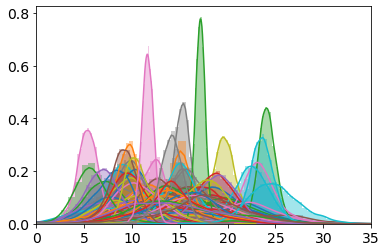

In [31]:
for i, c in enumerate(deaths):
    sns.distplot(samples['t0'][:,i])
plt.xlim(0, 35)

(0.8, 2)

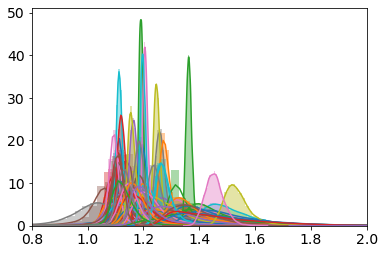

In [28]:
for i, c in enumerate(deaths):
    sns.distplot(samples['GR1'][:,i])
plt.xlim(0.8, 1.8)

(0.8, 1.5)

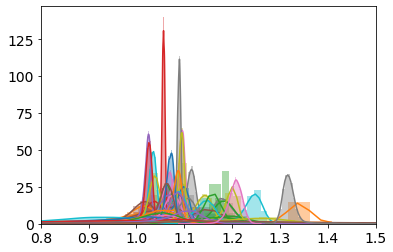

In [30]:
for i, c in enumerate(deaths):
    sns.distplot(samples['GR2'][:,i])
plt.xlim(0.8, 1.5)

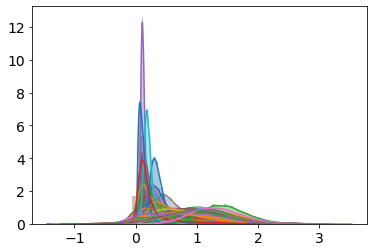

In [48]:
for i, c in enumerate(deaths):
    sns.distplot(samples['Decay'][:,i])
# plt.xlim(0.8, 1.5)

# Trace Plots

Text(0, 0.5, 'Growth Rate')

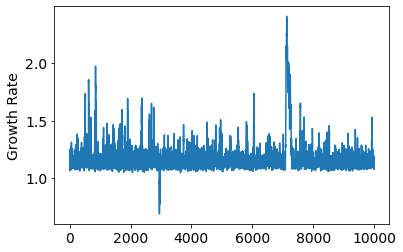

In [49]:
plt.plot(samples['GR1'][:,1])
plt.ylabel('Growth Rate')

Text(0, 0.5, 'Growth Rate')

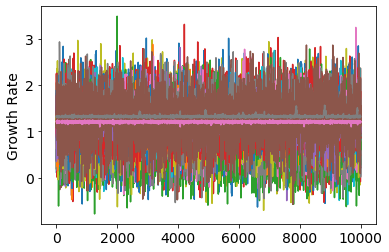

In [34]:
plt.plot(samples['GR2'])
plt.ylabel('Growth Rate')

Text(0, 0.5, 'Time of intervention')

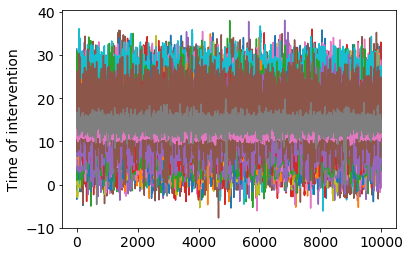

In [35]:
plt.plot(samples['t0'])
plt.ylabel('Time of intervention')

Text(0, 0.5, 'Initial Deaths')

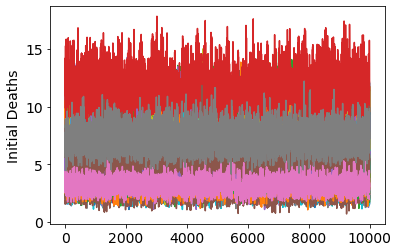

In [33]:
plt.plot(samples['Di'])
plt.ylabel('Initial Deaths')

Text(0, 0.5, 'Decay Time')

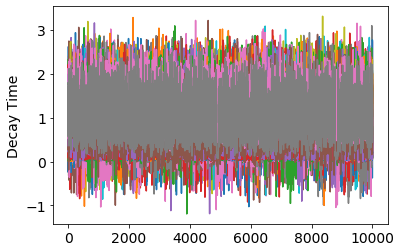

In [37]:
plt.plot(samples['Decay'])
plt.ylabel('Decay Time')